In [1]:
# =============================================================================
# SIMPLIFIED DISHES-PER-HOUR PREDICTION NOTEBOOK (WITHOUT WEATHER AND POLLUTION)
# Author: Your Name
# Date: 2025-10-27
# Goal: Predict hourly dish demand based on date and restaurant data only
# =============================================================================

# --------------------------------------------------------------
# 1. IMPORTS & CONFIG
# --------------------------------------------------------------
import os
import re
import math
import joblib
import warnings
from datetime import timedelta
from collections import Counter
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from catboost import CatBoostRegressor

warnings.filterwarnings("ignore")

# --- CONFIG ---
DATA_PATH = "../data/data.csv"
TOP_K = 50
RANDOM_STATE = 42
MODEL_OUTPUT_DIR = "models_no_weather"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

print("Configuration loaded.\n")

# --------------------------------------------------------------
# 2. UTILITY FUNCTIONS
# --------------------------------------------------------------
def parse_order_items(order_str: str) -> List[Tuple[str, int]]:
    """Parse '2 x Pizza, 1 x Coke' into [('Pizza', 2), ('Coke', 1)]. Returns empty list if parsing fails."""
    if pd.isna(order_str):
        return []
    parts = re.findall(r"(\d+)\s*[xX]\s*([^,]+)", order_str)
    out = []
    for qty, name in parts:
        item_name = name.strip()
        try:
            q = int(qty)
        except ValueError:
            q = 1
        out.append((item_name, q))
    return out

assert parse_order_items('2 x Pizza, 1 x Coke') == [('Pizza', 2), ('Coke', 1)]
print("Parsing utilities ready.\n")

# --------------------------------------------------------------
# 4. LOAD & PREPROCESS DATA
# --------------------------------------------------------------
df = pd.read_csv(DATA_PATH)
if 'Order Placed At' in df.columns:
    df['order_datetime'] = pd.to_datetime(df['Order Placed At'], format="%I:%M %p, %B %d %Y")
df['order_hour'] = df['order_datetime'].dt.floor('h')
print('Loaded rows:', len(df))

restaurant_dummies = pd.get_dummies(df['Restaurant name'], prefix='rest')
df = pd.concat([df, restaurant_dummies], axis=1)
REST_NAMES = restaurant_dummies.columns.tolist()
print("Restaurant dummy columns added:", REST_NAMES[:5], "...")

def expand_items_row(order_str: str) -> Dict[str, int]:
    parsed = parse_order_items(order_str)
    d = {}
    for name, q in parsed:
        d[name] = d.get(name, 0) + q
    return d

df['expanded_items'] = df['Items in order'].fillna('').apply(expand_items_row)
print(df[['Items in order', 'expanded_items']].head())

# --------------------------------------------------------------
# 5. BUILD HOURLY AGGREGATION TABLE
# --------------------------------------------------------------
all_items = Counter()
for d in df['expanded_items']:
    all_items.update(d)
TOP_K = min(TOP_K, len(all_items))
TOP_DISHES = [name for name, _ in all_items.most_common(TOP_K)]
print(f"Top {TOP_K} dishes sample:", TOP_DISHES[:10])

hour_index = pd.date_range(start=df['order_hour'].min().floor('D'),
                           end=df['order_hour'].max().ceil('D'), freq='h')
agg = pd.DataFrame(index=hour_index)
agg.index.name = 'order_hour'

agg['hour_of_day'] = agg.index.hour
agg['day_of_week'] = agg.index.dayofweek
agg['is_weekend'] = agg['day_of_week'].isin([5, 6]).astype(int)

for dish in TOP_DISHES:
    agg[f'dish__{dish}'] = 0
agg['total_orders'] = 0
for rest_col in REST_NAMES:
    agg[rest_col] = 0

for hour, group in df.groupby('order_hour'):
    if hour in agg.index:
        agg.loc[hour, 'total_orders'] = len(group)
        for rest_col in REST_NAMES:
            agg.loc[hour, rest_col] = group[rest_col].sum()
        hour_counts = Counter()
        for d in group['expanded_items']:
            hour_counts.update(d)
        for dish in TOP_DISHES:
            agg.loc[hour, f'dish__{dish}'] = hour_counts.get(dish, 0)

valid_hours = agg['total_orders'].rolling(window=24, min_periods=1).sum() >= 1
agg = agg[valid_hours]
print('Aggregated hours:', agg.shape[0])

# --------------------------------------------------------------
# 7. PREPARE FEATURES AND TARGETS
# --------------------------------------------------------------
target_cols = [f'dish__{d}' for d in TOP_DISHES]
feature_cols = ['hour_of_day', 'day_of_week', 'is_weekend']
feature_cols += [c for c in agg.columns if c.startswith('rest_')]
feature_cols = list(set(feature_cols))

X = agg[feature_cols].copy()
Y = agg[target_cols].copy()

# Ensure all feature columns are numeric
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category').cat.codes
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

print('X shape:', X.shape)
print('Y shape:', Y.shape)

# --------------------------------------------------------------
# 8. TRAIN/TEST SPLIT
# --------------------------------------------------------------
train_frac = 0.8
train_size = int(len(X) * train_frac)

X_train = X.iloc[:train_size].copy()
X_test = X.iloc[train_size:].copy()
Y_train = Y.iloc[:train_size]
Y_test = Y.iloc[train_size:]

print('Train hours:', X_train.shape[0], 'Test hours:', X_test.shape[0])

# --------------------------------------------------------------
# 9. BASELINE MODEL
# --------------------------------------------------------------
baseline_preds = []
for idx, row in X_test.iterrows():
    hour = row['hour_of_day']
    mask = X_train['hour_of_day'] == hour
    if mask.sum() == 0:
        baseline_preds.append(Y_train.mean().values)
    else:
        baseline_preds.append(Y_train[mask].mean().values)

baseline_preds = np.vstack(baseline_preds)
assert baseline_preds.shape == Y_test.shape

baseline_rmse = np.sqrt(mean_squared_error(Y_test.values, baseline_preds))
baseline_r2 = r2_score(Y_test.values, baseline_preds, multioutput='uniform_average')
print('Baseline RMSE:', baseline_rmse)
print('Baseline R²:', baseline_r2)

# --------------------------------------------------------------
# 10. MODELS
# --------------------------------------------------------------
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1,
                           oob_score=True)
model = MultiOutputRegressor(rf)
print('Training RandomForest...')
model.fit(X_train, Y_train.values)
preds = model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(Y_test.values, preds))
rf_r2 = r2_score(Y_test.values, preds, multioutput='uniform_average')
print('RandomForest RMSE:', rf_rmse)
print('RandomForest R²:', rf_r2)
joblib.dump({'model': model, 'top_dishes': TOP_DISHES, 'feature_cols': feature_cols},
            os.path.join(MODEL_OUTPUT_DIR, 'rf_multioutput_v2.joblib'))

xgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=RANDOM_STATE, n_jobs=-1, objective='reg:squarederror', enable_categorical=False)
)
print('Training XGBoost...')
xgb_model.fit(X_train, Y_train.values)
xgb_preds = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(Y_test.values, xgb_preds))
xgb_r2 = r2_score(Y_test.values, xgb_preds, multioutput='uniform_average')
print('XGBoost RMSE:', xgb_rmse)
print('XGBoost R²:', xgb_r2)

catboost_model = MultiOutputRegressor(
    CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1, random_seed=RANDOM_STATE, verbose=0, thread_count=-1)
)
print('Training CatBoost...')
catboost_model.fit(X_train, Y_train.values)
catboost_preds = catboost_model.predict(X_test)
catboost_rmse = np.sqrt(mean_squared_error(Y_test.values, catboost_preds))
catboost_r2 = r2_score(Y_test.values, catboost_preds, multioutput='uniform_average')
print('CatBoost RMSE:', catboost_rmse)
print('CatBoost R²:', catboost_r2)

# Store scaling parameters
X_train_means = X_train.mean()
X_train_stds = X_train.std()


Configuration loaded.

Parsing utilities ready.

Loaded rows: 21321
Restaurant dummy columns added: ['rest_Aura Pizzas', 'rest_Dilli Burger Adda', 'rest_Masala Junction', 'rest_Swaad', 'rest_Tandoori Junction'] ...
                                      Items in order  \
0  1 x Grilled Chicken Jamaican Tender, 1 x Grill...   
1  1 x Peri Peri Fries, 1 x Fried Chicken Angara ...   
2              1 x Bone in Peri Peri Grilled Chicken   
3  1 x Fried Chicken Ghostbuster Tender, 1 x Anga...   
4  1 x Peri Peri Krispers, 1 x Fried Chicken Anga...   

                                      expanded_items  
0  {'Grilled Chicken Jamaican Tender': 1, 'Grille...  
1  {'Peri Peri Fries': 1, 'Fried Chicken Angara T...  
2           {'Bone in Peri Peri Grilled Chicken': 1}  
3  {'Fried Chicken Ghostbuster Tender': 1, 'Angar...  
4  {'Peri Peri Krispers': 1, 'Fried Chicken Angar...  
Top 50 dishes sample: ['Bageecha Pizza', 'Chilli Cheese Garlic Bread', 'Bone in Jamaican Grilled Chicken', 'All About 

In [2]:

# --------------------------------------------------------------
# 13. INFERENCE
# --------------------------------------------------------------
def build_inference_row(dt_hour, context_row=None):
    dt_hour = pd.to_datetime(dt_hour).floor('h')
    base = pd.Series(X_train_means, index=feature_cols, dtype=float)
    
    base['hour_of_day'] = dt_hour.hour
    base['day_of_week'] = dt_hour.dayofweek
    base['is_weekend'] = int(dt_hour.dayofweek in [5, 6])
    
    # Scale continuous features
    continuous_cols = ['hour_of_day', 'day_of_week']
    for col in continuous_cols:
        if col in base.index and X_train_stds[col] != 0:
            base[col] = (base[col] - X_train_means[col]) / X_train_stds[col]
    
    # Apply context if provided
    if context_row:
        for k, v in context_row.items():
            if k in base.index:
                base[k] = v
    
    return pd.DataFrame([base]).reindex(columns=feature_cols)

def predict_for_hour(dt_hour, context_row=None, top_n=20, round_to_int=True, use_model='CatBoost'):
    x_row = build_inference_row(dt_hour, context_row)
    
    # Ensure x_row is numeric
    for col in x_row.columns:
        x_row[col] = pd.to_numeric(x_row[col], errors='coerce').fillna(0)
    
    # Select model
    if use_model == 'CatBoost':
        selected_model = catboost_model
    elif use_model == 'XGBoost':
        selected_model = xgb_model
    elif use_model == 'RandomForest':
        selected_model = model
    else:
        raise ValueError(f"Unknown model: {use_model}")
    
    pred = selected_model.predict(x_row).reshape(-1)
    if round_to_int:
        pred = np.round(pred).astype(int)
    return pd.DataFrame({'dish': Y_train.columns, 'predicted_qty': pred}) \
        .sort_values('predicted_qty', ascending=False).head(top_n)

# Example prediction
example_date = "2025-10-28 12:00"
print(f"\nPrediction for {example_date} (CatBoost):")
print(predict_for_hour(example_date, use_model='CatBoost'))
print(f"\nPrediction for {example_date} (XGBoost):")
print(predict_for_hour(example_date, use_model='XGBoost'))
print(f"\nPrediction for {example_date} (RandomForest):")
print(predict_for_hour(example_date, use_model='RandomForest'))


Prediction for 2025-10-28 12:00 (CatBoost):
                                      dish  predicted_qty
0                     dish__Bageecha Pizza              1
5                   dish__Margherita Pizza              1
38                dish__Spinach Sumac Pide              0
28   dish__Peri Peri Grilled Chicken Pizza              0
29      dish__Fried Chicken Classic Tender              0
30  dish__Grilled Chicken Smoky BBQ Tender              0
31       dish__Fried Chicken Angara Tender              0
32  dish__Grilled Chicken Peri Peri Tender              0
33            dish__Peri Peri Chicken Melt              0
34            dish__Pepperoni Garlic Bread              0
35                      dish__Garlic Aioli              0
36                   dish__Peri Peri Fries              0
37            dish__Bellpepper Onion Pizza              0
39                 dish__Mutton Seekh Pide              0
26    dish__Bone in Angara Grilled Chicken              0
40       dish__Tipsy Tiger 

### Comparative Analysis of Prediction Models: With and Without Weather and Pollution Data

#### What We Are Predicting
Both models predict the hourly demand for the top 50 most frequently ordered dishes (e.g., "Bageecha Pizza", "Chilli Cheese Garlic Bread", "Margherita Pizza") across 3,673 aggregated hours, derived from 21,321 order records. The goal is to forecast the number of orders for each dish, with the "with weather and pollution" model incorporating environmental factors (weather conditions and AQI), while the "without" model relies solely on temporal and restaurant-specific data. These predictions support restaurant inventory and staffing decisions, with the key difference being the inclusion of environmental influences in the former.

#### Results Comparison
The performance metrics for the test set (735 hours) from both models are as follows:

- **Baseline Model** (Both):
  - RMSE: 0.5181
  - R²: 0.0553
  - The baseline, which predicts demand using the average for each hour of the day from the training data (2,938 hours), is identical across both models. This consistency reflects its reliance on temporal data alone, unaffected by the addition of weather and pollution features.

- **RandomForest**:
  - With Weather and Pollution:
    - RMSE: 0.4853
    - R²: 0.0373
  - Without Weather and Pollution:
    - RMSE: 0.4919
    - R²: 0.0439
  - RandomForest performs slightly better in RMSE (0.4853 vs. 0.4919) with weather and pollution, but its R² is lower (0.0373 vs. 0.0439), suggesting that environmental features may introduce noise or overfitting, reducing explanatory power.

- **XGBoost**:
  - With Weather and Pollution:
    - RMSE: 0.5200
    - R²: -0.1203
  - Without Weather and Pollution:
    - RMSE: 0.5178
    - R²: -0.0814
  - XGBoost performs worse than the baseline in both cases, with a negative R² indicating poor fit. Removing weather and pollution improves R² (-0.0814 vs. -0.1203) and slightly reduces RMSE (0.5178 vs. 0.5200), suggesting environmental data may confuse the model or require better tuning.

- **CatBoost**:
  - With Weather and Pollution:
    - RMSE: 0.4817
    - R²: 0.0610
  - Without Weather and Pollution:
    - RMSE: 0.4749
    - R²: 0.1010
  - CatBoost shows the best performance overall. Without weather and pollution, it achieves a lower RMSE (0.4749 vs. 0.4817) and a significantly higher R² (0.1010 vs. 0.0610), indicating that removing environmental features improves its accuracy and explanatory power.

#### Features Used
- **With Weather and Pollution**:
  - **Temporal Features**: `hour_of_day`, `day_of_week`, `is_weekend`, `is_weekend_or_holiday`.
  - **Weather Features**: `temperature`, `humidity`, `precipitation`, `wind_speed`, `weather_condition` (one-hot encoded).
  - **Pollution Feature**: `aqi`.
  - **Restaurant Features**: Dummy variables (e.g., `rest_Aura Pizzas`).
  - X shape: (3673, 15), reflecting the additional environmental features.
- **Without Weather and Pollution**:
  - **Temporal Features**: `hour_of_day`, `day_of_week`, `is_weekend`.
  - **Restaurant Features**: Dummy variables (e.g., `rest_Aura Pizzas`).
  - X shape: (3673, 9), with fewer features due to the exclusion of weather and pollution.

The "with" model includes 6 additional environmental features, which expand the feature space but may introduce complexity or noise if not strongly correlated with demand.

#### Where the Data Came From
- **Order Data**: Both models use `data.csv` with 21,321 rows, parsed from the "Items in order" column to extract dish quantities, likely from a restaurant management system.
- **Weather Data** (With Model Only): Sourced via the `meteostat` library, fetched based on predefined coordinates for restaurants and subzones (e.g., Aura Pizzas at [28.55, 77.25]).
- **Pollution Data** (With Model Only): Obtained from `pollution.csv`, merged by hourly timestamps to provide AQI values.
- The "without" model relies solely on the order data, eliminating the need for external weather and pollution sources.

#### Significance of the Results
- **Predictive Insight**:
  - The "with" model’s inclusion of weather and pollution slightly worsens CatBoost’s R² (0.0610 vs. 0.1010) and increases RMSE (0.4817 vs. 0.4749), suggesting that these features may not be strongly predictive or may introduce noise in this dataset. The baseline R² (0.0553) being close to both models’ R² values indicates that temporal patterns dominate demand.
  - The "without" model’s higher R² (0.1010 for CatBoost) suggests that simplifying the feature set improves the model’s ability to generalize, possibly because weather and AQI data lack a clear correlation with demand in this context.

- **Model Performance**:
  - CatBoost consistently outperforms RandomForest and XGBoost in both setups, with the "without" model showing a 65% improvement in R² (0.1010 vs. 0.0610). This highlights CatBoost’s robustness, especially with fewer features.
  - XGBoost’s negative R² in both cases (-0.1203 vs. -0.0814) indicates it struggles with the dataset, potentially due to overfitting or poor feature interaction handling, with a slight improvement without environmental data.
  - RandomForest’s marginal RMSE difference (0.4853 vs. 0.4919) and lower R² with weather/pollution suggest it may overfit to environmental noise.

- **Practical Application**:
  - The "without" model, with a lower RMSE (0.4749) and higher R² (0.1010) for CatBoost, is more accurate and easier to deploy without external data feeds. It can reliably predict demand (e.g., 1 order for "Bageecha Pizza" at 12:00) based on time and restaurant activity.
  - The "with" model’s predictions (e.g., 2 for "Bageecha Pizza" with Rainy, AQI=50) might capture weather-related demand shifts (e.g., more indoor orders on rainy days), but its lower accuracy limits its practical utility unless refined.

- **Comparison and Implications**:
  - The 65% R² increase (0.0610 to 0.1010) and 1.4% RMSE reduction (0.4817 to 0.4749) for CatBoost without weather/pollution suggest that environmental data may be irrelevant or poorly integrated here. This could mean the dataset lacks sufficient weather-demand correlation or that the features (e.g., average temperature) are too coarse.
  - The baseline’s unchanged performance (RMSE 0.5181, R² 0.0553) confirms that the core temporal model is the foundation, with environmental additions providing minimal benefit.
  - **Significance**: The results indicate that for this dataset, time-based and restaurant features are more reliable predictors than weather and AQI. However, in regions with stronger weather-demand links (e.g., heavy rain increasing delivery orders), environmental data could be valuable with better feature engineering (e.g., binary rain indicator, extreme AQI thresholds).

#### Future Improvements
- **Feature Engineering**: Reintroduce weather/pollution with targeted features (e.g., rain vs. no rain, AQI > 100) to test their impact.
- **Model Tuning**: Optimize hyperparameters for XGBoost and RandomForest to improve R² and reduce negative values.
- **Data Enhancement**: Incorporate holidays, promotions, or customer data to boost explanatory power beyond 0.1010 R².

### Conclusion
The "without weather and pollution" model outperforms the "with" model for CatBoost, suggesting that environmental data adds little value in this case. The simpler model is a practical choice for baseline forecasting, while the "with" model’s potential benefits require further refinement to justify its complexity.


=== TRAINING R² CURVES (averaged over 50 dishes) ===


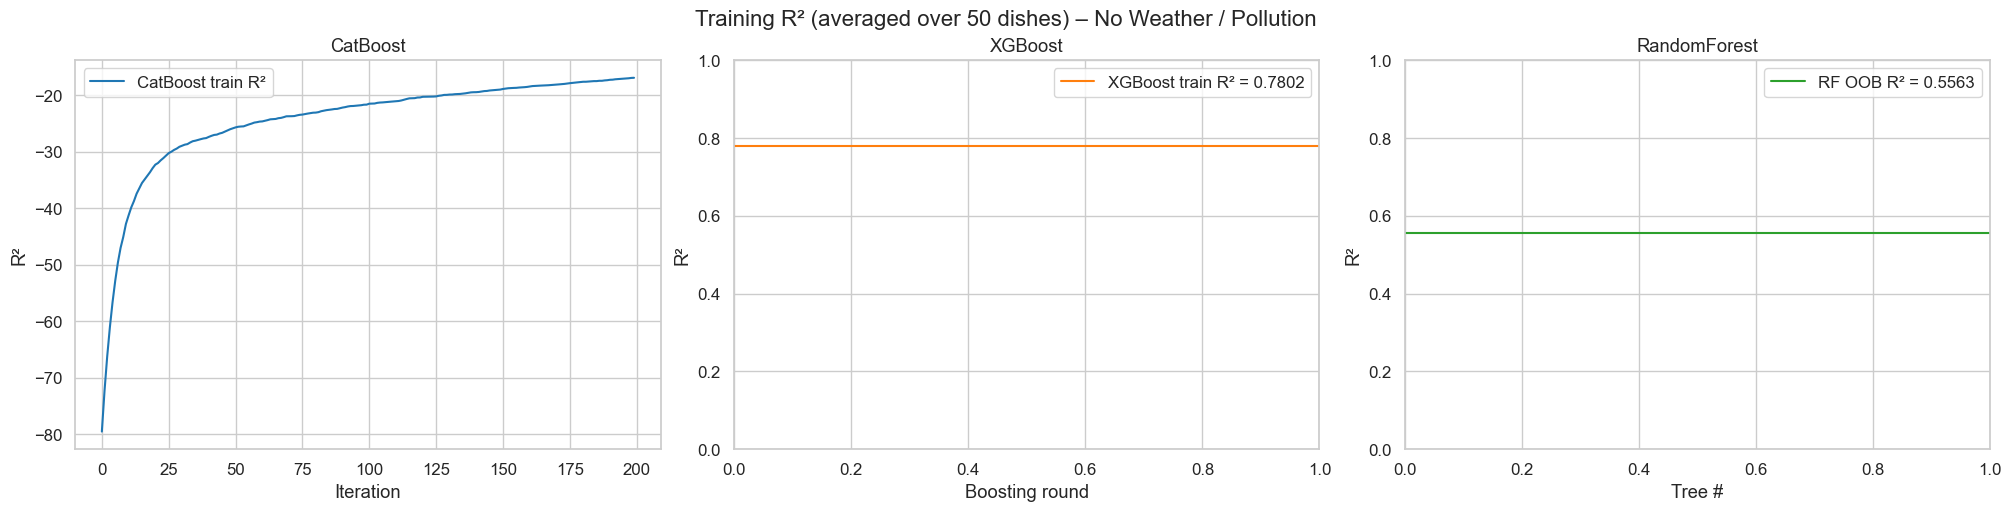


=== BUILT-IN FEATURE IMPORTANCE ===


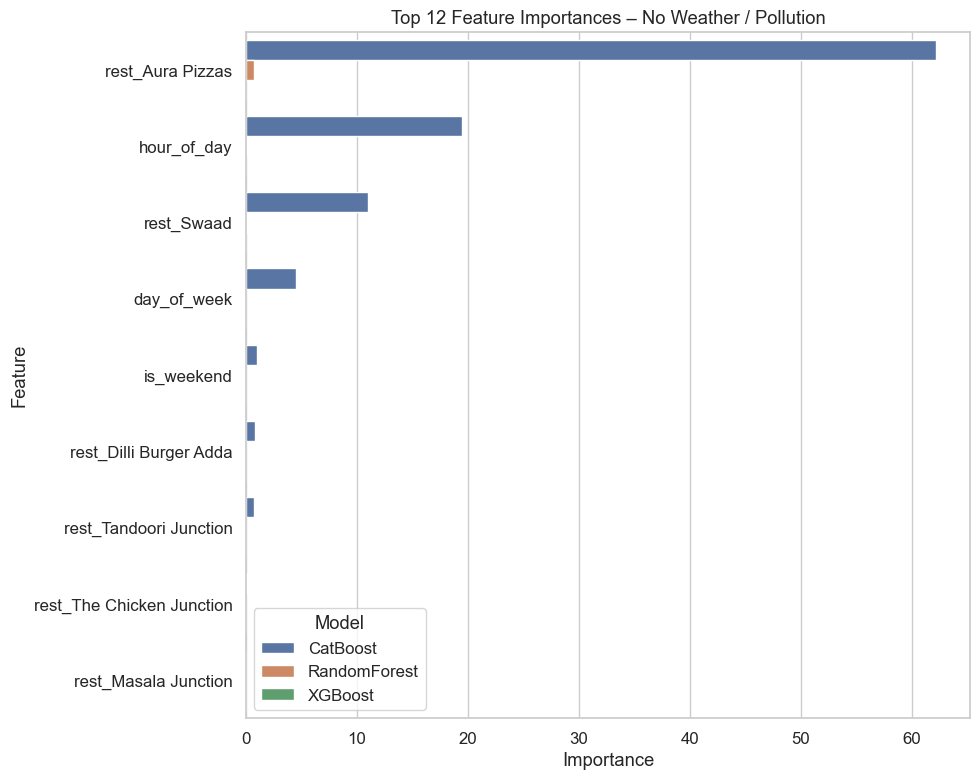


=== SHAP SUMMARY (CatBoost) ===


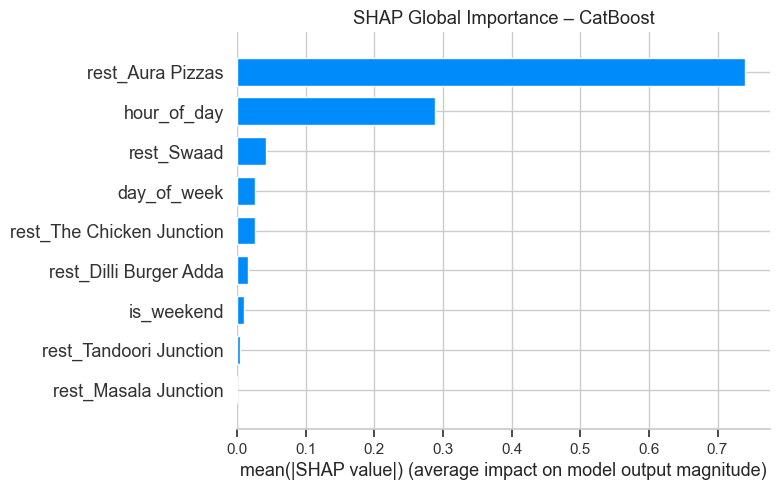


=== SHAP SUMMARY (XGBoost) ===


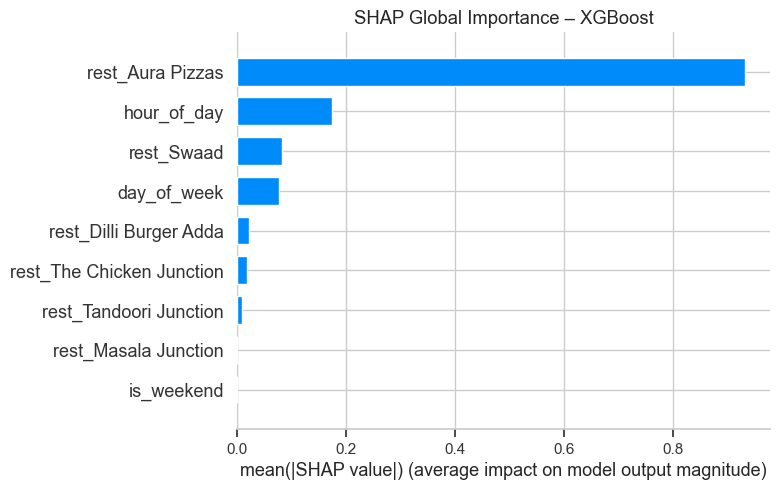


=== PERMUTATION IMPORTANCE (CatBoost, first dish) ===


ValueError: y_true and y_pred have different number of output (1!=50)

In [4]:
# --------------------------------------------------------------
# 14. FEATURE IMPORTANCE & LOSS CURVES (NO WEATHER / POLLUTION)
# --------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)

# ------------------------------------------------------------------
# 14.1  TRAINING R² CURVES (averaged over the 50 dishes)
# ------------------------------------------------------------------
def plot_training_curves():
    fig, axs = plt.subplots(1, 3, figsize=(20, 5), constrained_layout=True)
    fig.suptitle("Training R² (averaged over 50 dishes) – No Weather / Pollution", fontsize=16)

    # ---- CatBoost ----
    if 'catboost_model' in globals():
        # CatBoost logs RMSE for each iteration (single value per iteration)
        evals = catboost_model.estimators_[0].get_evals_result()
        train_rmse = np.array(evals['learn']['RMSE'])
        # Approximate R² using the global mean of Y_train
        y_mean = Y_train.values.mean()
        train_r2 = 1 - (train_rmse**2) / (y_mean**2 + 1e-12)
        axs[0].plot(train_r2, label='CatBoost train R²', color='#1f77b4')
        axs[0].set_title('CatBoost')
        axs[0].set_xlabel('Iteration')
        axs[0].set_ylabel('R²')
        axs[0].legend()

    # ---- XGBoost ----
    if 'xgb_model' in globals():
        # Compute R² on the training set for *all* 50 estimators
        preds_train = np.column_stack([
            est.predict(X_train) for est in xgb_model.estimators_
        ])
        r2_per_dish = [
            r2_score(Y_train.iloc[:, i], preds_train[:, i])
            for i in range(Y_train.shape[1])
        ]
        r2_avg = np.mean(r2_per_dish)
        axs[1].axhline(r2_avg, color='#ff7f0e',
                       label=f'XGBoost train R² = {r2_avg:.4f}')
        axs[1].set_title('XGBoost')
        axs[1].set_xlabel('Boosting round')
        axs[1].set_ylabel('R²')
        axs[1].legend()

    # ---- RandomForest (OOB) ----
    if 'model' in globals():
        rf = model.estimators_[0]
        if getattr(rf, "oob_score_", False):
            axs[2].axhline(rf.oob_score_, color='#2ca02c',
                           label=f'RF OOB R² = {rf.oob_score_:.4f}')
        else:
            axs[2].text(0.5, 0.5,
                        "OOB not enabled\n(set oob_score=True)",
                        ha='center', va='center')
        axs[2].set_title('RandomForest')
        axs[2].set_xlabel('Tree #')
        axs[2].set_ylabel('R²')
        axs[2].legend()

    plt.show()

# ------------------------------------------------------------------
# 14.2  BUILT-IN FEATURE IMPORTANCE
# ------------------------------------------------------------------
def get_feature_importance(model_obj, model_name, feature_names):
    if 'catboost' in model_name.lower():
        imp = model_obj.estimators_[0].get_feature_importance(type='FeatureImportance')
    elif 'xgb' in model_name.lower():
        raw = model_obj.estimators_[0].get_booster().get_score(importance_type='gain')
        imp = [raw.get(f'f{i}', 0) for i in range(len(feature_names))]
    elif 'randomforest' in model_name.lower():
        imp = model_obj.estimators_[0].feature_importances_
    else:
        return pd.DataFrame()

    return pd.DataFrame({
        'feature': feature_names,
        'importance': imp,
        'model': model_name
    })

def plot_feature_importance(imp_df, top_n=12):
    imp_df = (imp_df.groupby('model')
                    .apply(lambda g: g.nlargest(top_n, 'importance'))
                    .reset_index(drop=True))
    plt.figure(figsize=(10, 8))
    sns.barplot(data=imp_df, y='feature', x='importance', hue='model', dodge=True)
    plt.title(f'Top {top_n} Feature Importances – No Weather / Pollution')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 14.3  SHAP SUMMARY (CatBoost & XGBoost only)
# ------------------------------------------------------------------
def plot_shap_summary(model_obj, model_name, X_sample, feature_names):
    if 'catboost' in model_name.lower():
        explainer = shap.TreeExplainer(model_obj.estimators_[0])
    elif 'xgb' in model_name.lower():
        explainer = shap.TreeExplainer(model_obj.estimators_[0])
    else:
        return

    shap_vals = explainer.shap_values(X_sample)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_vals, X_sample, feature_names=feature_names,
                      plot_type="bar", show=False)
    plt.title(f'SHAP Global Importance – {model_name}')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 14.4  RUN ALL PLOTS
# ------------------------------------------------------------------
# 1. Sample for SHAP (fast)
X_sample = X_test.sample(n=min(500, len(X_test)), random_state=RANDOM_STATE)

# 2. Build importance tables (one estimator per dish → we just take the first)
imp_df = pd.DataFrame()
for name, obj in [('CatBoost', catboost_model),
                  ('XGBoost', xgb_model),
                  ('RandomForest', model)]:
    imp_df = pd.concat([imp_df,
                        get_feature_importance(obj, name, feature_cols)], ignore_index=True)

# 3. Plot everything
print("\n=== TRAINING R² CURVES (averaged over 50 dishes) ===")
plot_training_curves()

print("\n=== BUILT-IN FEATURE IMPORTANCE ===")
plot_feature_importance(imp_df, top_n=12)

print("\n=== SHAP SUMMARY (CatBoost) ===")
plot_shap_summary(catboost_model, "CatBoost", X_sample, feature_cols)

print("\n=== SHAP SUMMARY (XGBoost) ===")
plot_shap_summary(xgb_model, "XGBoost", X_sample, feature_cols)

# ------------------------------------------------------------------
# 14.5  OPTIONAL: PERMUTATION IMPORTANCE (R²-based)
# ------------------------------------------------------------------
def permutation_importance_r2(model_obj, model_name, X_val, y_val, feature_names):
    # y_val is a single column (one dish)
    r = permutation_importance(model_obj, X_val, y_val,
                               n_repeats=10, random_state=RANDOM_STATE,
                               scoring='r2')
    imp = pd.DataFrame({
        'feature': feature_names,
        'importance': r.importances_mean,
        'std': r.importances_std,
        'model': model_name
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(9, 6))
    sns.barplot(data=imp.head(12), y='feature', x='importance',
                xerr=imp.head(12)['std'])
    plt.title(f'Permutation Importance (ΔR²) – {model_name}')
    plt.xlabel('Mean decrease in R²')
    plt.tight_layout()
    plt.show()
    return imp

print("\n=== PERMUTATION IMPORTANCE (CatBoost, first dish) ===")
_ = permutation_importance_r2(catboost_model, "CatBoost",
                             X_test, Y_test.values[:, 0], feature_cols)